In [183]:
#..........................案例1:
#.......................... 回归[决策树、随机森林]预测房价

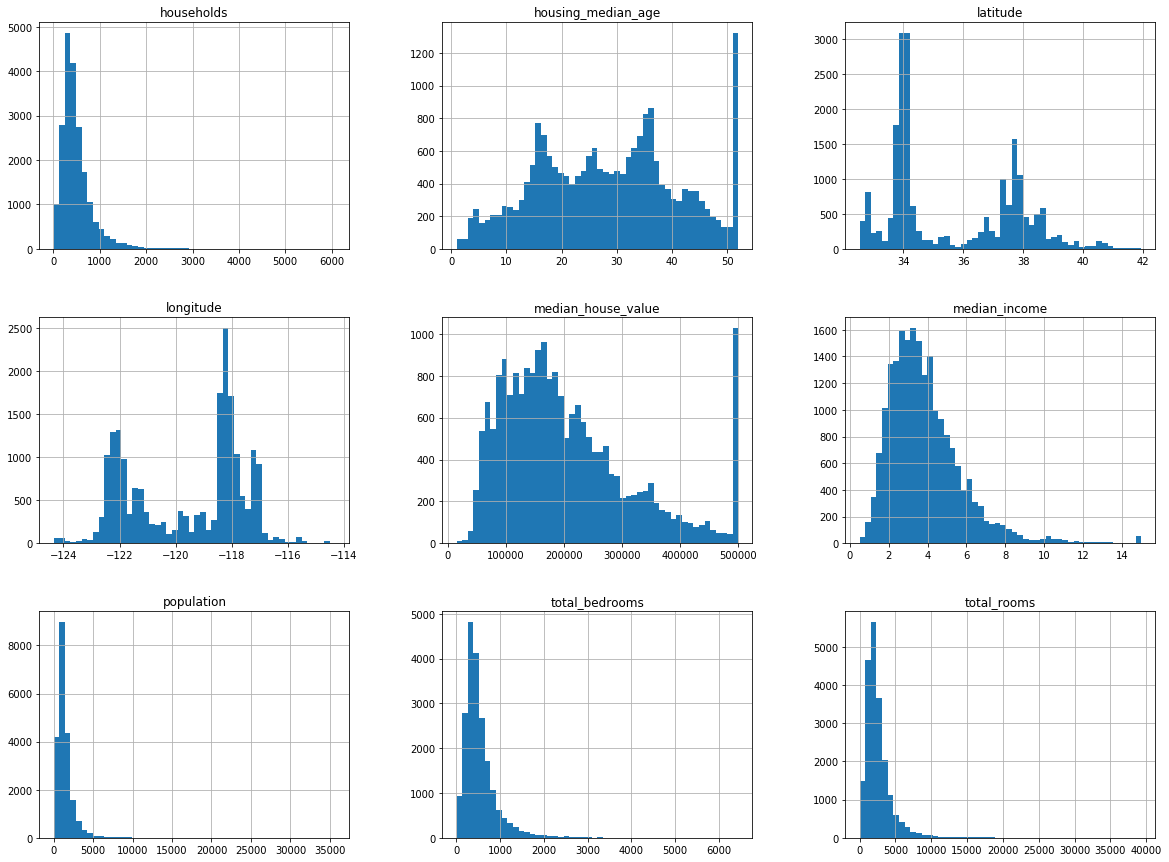

分层抽样结果：
 3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64


In [184]:
#..........拆分train和test数据集
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 查看数据分布
file=r'C:\Users\Wudey\Desktop\housing.csv'
dta=pd.read_table(file,sep=',')
dta.hist(bins=50,figsize=(20,15))
plt.show()

# 随机抽样(按行数随机拆)
from sklearn.model_selection import train_test_split
trian_s,test_s=train_test_split(dta,test_size=0.2,random_state=20) #random_state相当于seed

# 分层抽样（假设median_income非常重要）
# 分层
from sklearn.model_selection import StratifiedShuffleSplit
dta['income_cat']=np.ceil(dta['median_income']/1.5) # 不除会分成15份，太多了，每份样本量不足会造成偏差
# print(dta['income_cat'].value_counts())
dta["income_cat"].where(dta["income_cat"] < 5, 5.0, inplace=True) # 大于5的归为5
# print(dta.loc[:,('income_cat','median_income')].head(5))
# 抽样
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # 1表示分为1组
for train_index, test_index in split.split(dta, dta["income_cat"]):
    trian_s = dta.loc[train_index]
    test_s = dta.loc[test_index]
print('分层抽样结果：\n',dta["income_cat"].value_counts() / len(dta))
for set in (trian_s, test_s):
    set.drop(["income_cat"], axis=1, inplace=True) # 删除作为分层的变量

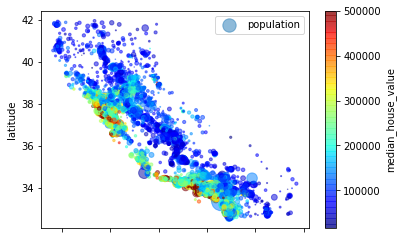

与价格的相关系数：
 latitude             -0.142724
longitude            -0.047432
population           -0.026920
total_bedrooms        0.047689
households            0.064506
housing_median_age    0.114110
total_rooms           0.135097
median_income         0.687160
median_house_value    1.000000
Name: median_house_value, dtype: float64

与价格的相关系数（添加变量）：
 bedrooms_per_room          -0.259984
latitude                   -0.142724
longitude                  -0.047432
population                 -0.026920
population_per_household   -0.021985
total_bedrooms              0.047689
households                  0.064506
housing_median_age          0.114110
total_rooms                 0.135097
rooms_per_household         0.146285
median_income               0.687160
median_house_value          1.000000
Name: median_house_value, dtype: float64


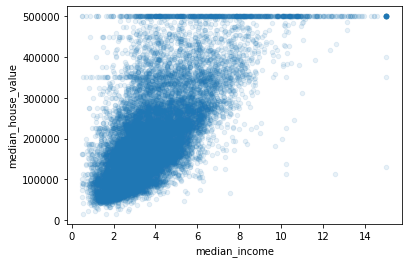

In [185]:
#..........探索train
housing = trian_s.copy() # 创建副本
housing.plot(kind="scatter", x="longitude", y="latitude",
             alpha=0.5,s=housing['population']/100,label='population',
             c="median_house_value",cmap=plt.get_cmap('jet')) # 地图
plt.show()
# 可以看到不同地区价格并不相同
cor=housing.corr()
print('与价格的相关系数：\n',cor['median_house_value'].sort_values())
# 相关图：
housing.plot(kind="scatter", x="median_income",y="median_house_value",alpha=0.1)
plt.show()
# 可以看到有一个明显的“顶”（还有几条直线）
# 造几个新变量
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
cor=housing.corr()
print('\n与价格的相关系数（添加变量）：\n',cor['median_house_value'].sort_values())

# 以下连接下一节，为了于Piple无缝连接，继承类
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [186]:
#..........数据清洗
housing = trian_s.drop("median_house_value", axis=1) # 把标签提出来
housing_labels0 = trian_s["median_house_value"].copy()
# 处理缺失值
# housing.dropna(subset=["total_bedrooms"]) # 删除缺失变量
# housing.drop("total_bedrooms", axis=1) # 删除变量
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median) # 中位数填充
# Scikit-Learn 提供了一个方便的类来处理缺失值： Imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
print('每个变量的中位数：\n',imputer.statistics_)
X = imputer.transform(housing_num) # 先要fit，才能tranform
housing_tr = pd.DataFrame(X, columns=housing_num.columns) # X是一个数组
# Scikit-Learn的设计：
# 估计器（estimator）、转换器（transformer）【fit_transform()】、预测器（predictor）
# 将字符转为数值
housing_cat = housing["ocean_proximity"]
housing_cat.factorize() # 类似于stata里的encode
# pandas直接生成虚拟变量
housing_cat=pd.get_dummies(housing_cat)
# Pipeline转换流水线
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # imputer已经定义，不带转换器
    ('attribs_adder', CombinedAttributesAdder()), # 生成新的变量
    ('std_scaler', StandardScaler()), # 标准化，带有转换器
])
new=['rooms_per_household', 'population_per_household','bedrooms_per_room']
newname=list(housing_num.columns)
newname.extend(new)
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr = pd.DataFrame(housing_num_tr, columns=newname)

每个变量的中位数：
 [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [187]:
# 回归
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
housing_cat=housing_cat.reset_index(drop=True) # 在生成housing_tr的时候，索引丢失了
housing_prepared0=pd.concat([housing_num_tr,housing_cat],axis=1)
lin_reg.fit(housing_prepared0, housing_labels0)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [189]:
# 回归评估（交叉验证）
# 自变量
housing = test_s.drop("median_house_value", axis=1) # 把标签提出来
# 因变量
housing_labels = test_s["median_house_value"].copy()
# 自变量（数值型）
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num_tr=num_pipeline.fit_transform(housing_num)
housing_num_tr = pd.DataFrame(housing_num_tr, columns=newname)
# 自变量（字符型）
housing_cat = housing["ocean_proximity"]
housing_cat=housing_cat.reset_index(drop=True) # 在生成housing_tr的时候，索引丢失了
housing_cat=pd.get_dummies(housing_cat)

housing_prepared=pd.concat([housing_num_tr,housing_cat],axis=1)
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
print('预测误差：\n',np.sqrt(lin_mse),'\n(y大多为120000-265000，误差有点大)')

预测误差：
 66973.71087993948 
(y大多为120000-265000，误差有点大)


In [190]:
# 初探决策树
# 初探随机森林
# 决策树
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared0, housing_labels0)
housing_predictions = tree_reg.predict(housing_prepared0)
lin_mse = mean_squared_error(housing_labels0, housing_predictions)
print('拟合误差（决策树）：\n',np.sqrt(lin_mse),'\n(拟合误差居然为0')
housing_predictions = tree_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
print('预测误差（决策树）：\n',np.sqrt(lin_mse),'\n(比线性结果更加糟糕)')
# 另一种交叉验证（K折，分成10份，每次1：9来交叉验证）
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared0, housing_labels0,
scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print("----\nMean（决策树）:", rmse_scores.mean())
print("Standard deviation（决策树）:", rmse_scores.std(),'\n这种交叉验证法能够得到误差的分布，很有用')
# 线性
scores = cross_val_score(lin_reg, housing_prepared0, housing_labels0,
scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print("----\nMean（线性回归）:", rmse_scores.mean())
print("Standard deviation（线性回归）:", rmse_scores.std(),'\n结果与线性回归相差不多')

#随机森林
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, housing_prepared0, housing_labels0,
scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print("----\nMean（随机森林）:", rmse_scores.mean())
print("Standard deviation（随机森林）:", rmse_scores.std(),'\n结果较好')

拟合误差（决策树）：
 0.0 
(拟合误差居然为0
预测误差（决策树）：
 108718.83918178525 
(比线性结果更加糟糕)
----
Mean（决策树）: 70984.11748835318
Standard deviation（决策树）: 2459.1261627066547 
这种交叉验证法能够得到误差的分布，很有用
----
Mean（线性回归）: 69052.46136345083
Standard deviation（线性回归）: 2731.6740017983507 
结果与线性回归相差不多
----
Mean（随机森林）: 50316.13447791435
Standard deviation（随机森林）: 1897.9130012505505 
结果较好


In [196]:
# 调参
# 选最优模型参数
from sklearn.model_selection import GridSearchCV
# 类似的还有RandomizedSearchCV，随机选
param_grid = [
{'n_estimators': [30], 'max_features': [6]},
{'bootstrap': [False], 'n_estimators': [3], 'max_features': [2]},
] # 所有想调的参数（1+1）
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
    scoring='neg_mean_squared_error') # 这里仍然使用的交叉验证
grid_search.fit(housing_prepared0, housing_labels0)
print('最好的参数:',grid_search.best_params_) # 最好的参数
# grid_search.best_estimator_ # 最佳估计器
cvres = grid_search.cv_results_ # 查看各训练的评分
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print('训练评分:',np.sqrt(-mean_score), params)

最好的参数: {'max_features': 6, 'n_estimators': 30}
训练评分: 50126.068907982946 {'max_features': 6, 'n_estimators': 30}
训练评分: 61782.227610759306 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}


In [211]:
print('变量的重要性：')
feature_importances=grid_search.best_estimator_.feature_importances_ # 看哪个变量比较重要
sorted(zip(feature_importances,list(housing_prepared0.columns)), reverse=True)
# 有些变量不那么重要，可以丢掉
# 最终的训练结果需要进行最终的交叉验证
# 这里不给出具体过程，与线性交叉验证一致


变量的重要性：


[(0.3409398118288552, 'median_income'),
 (0.14208115885751085, 'INLAND'),
 (0.10366441086231931, 'population_per_household'),
 (0.0758484469522816, 'longitude'),
 (0.07257996889726151, 'rooms_per_household'),
 (0.0642981458924044, 'bedrooms_per_room'),
 (0.06413461190340926, 'latitude'),
 (0.044274375640740785, 'housing_median_age'),
 (0.018288464069764865, 'total_rooms'),
 (0.017925103278219657, 'population'),
 (0.017615152590037673, 'households'),
 (0.016616438084363284, 'total_bedrooms'),
 (0.013334101426072545, '<1H OCEAN'),
 (0.005665671118052952, 'NEAR OCEAN'),
 (0.002637231810838928, 'NEAR BAY'),
 (9.69067878672798e-05, 'ISLAND')]